In [1]:
#%matplotlib ipympl
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Label distribution: (array([0, 1, 2]), array([32, 31, 37]))


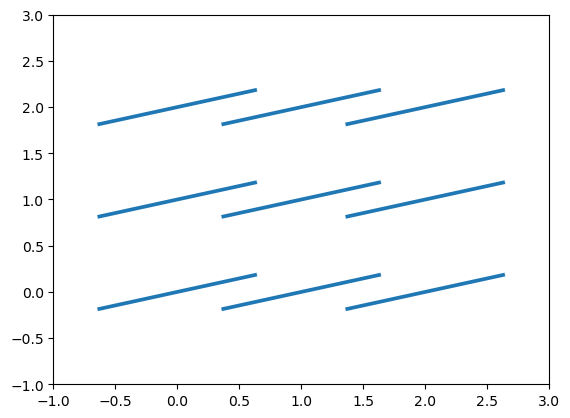

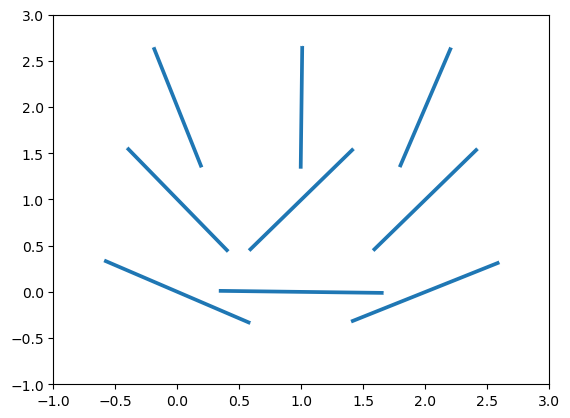

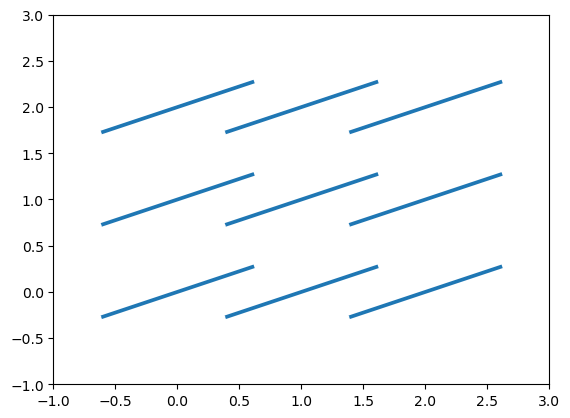

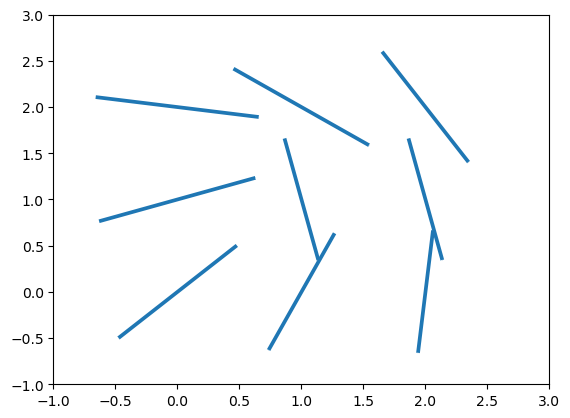

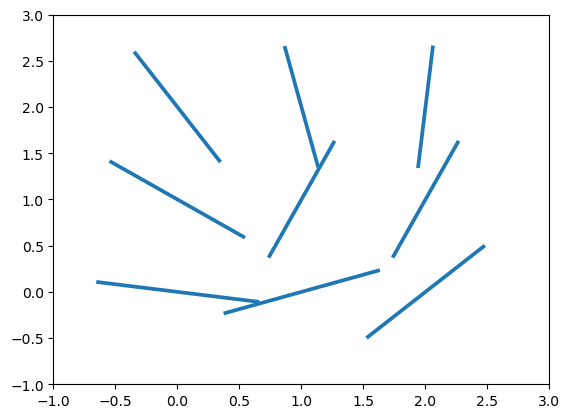

In [2]:
def generate_defect_field(size=100, defect_type='+1/2', defect_location=(1, 1), defect_strength=0.1):
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    field = np.zeros((size, size, 2))
    rotation = np.random.uniform(0,np.pi*2)
    # Generate a +1/2 defect
    if defect_type == '+1/2':
        charge = 0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0]) + rotation
        field[:, :, 0] = np.sin(theta) * defect_strength
        field[:, :, 1] = -np.cos(theta) * defect_strength

    # Generate a -1/2 defect
    elif defect_type == '-1/2':
        charge = -0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0]) + rotation
        field[:, :, 0] = -np.sin(theta) * defect_strength
        field[:, :, 1] = np.cos(theta) * defect_strength
    elif defect_type == 'none':
        theta = np.random.uniform(0,np.pi*2)
        field[:, :, 0] = np.sin(theta)
        field[:, :, 1] = -np.cos(theta)
    norm = np.sqrt(field[:,:,0]**2 + field[:,:,1]**2)
    field[:,:,0] = field[:,:,0]/norm
    field[:,:,1] = field[:,:,1]/norm
    return field

def plot_defect_field(field):
    size = field.shape[0]
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    plt.quiver(x,y,field[:, :, 0], field[:, :, 1],
                   pivot='mid',
                   headlength=0.2,
                   headwidth=0.2,
                   headaxislength=0.1,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.75
    )
    plt.xlim(-1,3)
    plt.ylim(-1,3)
    plt.show()

def generate_labeled_dataset(num_samples=100, size=100, defect_strength=0.1):
    X = []
    y = []

    for _ in range(num_samples):
        # Randomly choose a defect type and location
        defect_type = np.random.choice(['+1/2', '-1/2','none'])
        defect_location = (1,1)#(np.random.randint(size), np.random.randint(size))
        # Generate the defect field
        defect_field = generate_defect_field(size=size, defect_type=defect_type, defect_location=defect_location, defect_strength=defect_strength)

        # Append to the dataset
        X.append(defect_field.flatten())
        if defect_type == "+1/2":
            y.append(1)
        elif defect_type == "-1/2":
            y.append(2)
        else:
            y.append(0)
        #y.append(1 if defect_type == '+1/2' else 0)

    return np.array(X), np.array(y)
                    
# Example usage:
num_samples = 100
size = 3
defect_strength = 1#0.1

X, y = generate_labeled_dataset(num_samples=num_samples, size=size, defect_strength=defect_strength)

# Print labels to check the distribution of +1/2 and -1/2 defects
print("Label distribution:", np.unique(y, return_counts=True))

# Visualize a few examples
test_pos_field = generate_defect_field(size,"+1/2",(1,1),1)

# test_neg_field = generate_defect_field(size,"-1/2",(1,1),1)
# w = get_winding_number(test_neg_field,(1,1))
# print(w,"-1/2")
# w = calculate_winding_number(test_field)
# print(w)
        
for i in range(5):
    plot_defect_field(X[i].reshape((size, size, 2)))

(3, 3, 2)


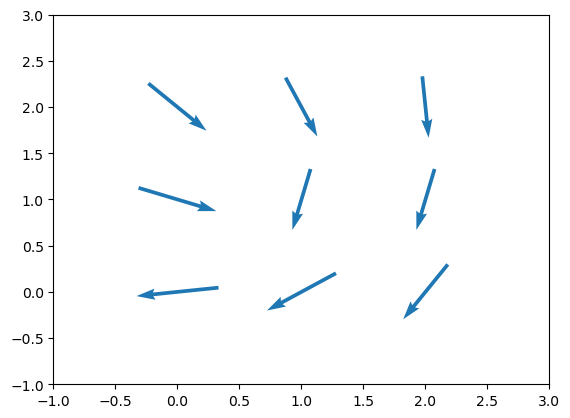

(1, 1)
0 (1, 2) -106.63080228469502 0.0 -106.63080228469502
1 (0, 2) -106.63080228469502 -129.13080228469502 22.5
0.0
22.5
2 (0, 1) -151.63080228469502 -151.63080228469502 0.0
22.5
22.5
3 (0, 0) -174.13080228469505 -174.13080228469505 0.0
22.5
22.5
4 (1, 0) -16.630802284695026 -16.630802284695026 0.0
22.5
22.5
5 (2, 0) -39.13080228469501 -39.13080228469501 0.0
22.5
22.5
6 (2, 1) -61.63080228469502 -61.63080228469502 0.0
22.5
22.5
7 (2, 2) -84.13080228469505 -84.13080228469505 0.0
22.5
22.5
22.5 +1/2


In [4]:
def get_winding_number(field,loc):
    """ returns a winding number in radians for the rotation of vectors around the defect core
    inputs:
            field: a 2d vector field [x,y,u,v] of director field
            loc: a tuple containing the defect location
    returns:
            w: winding number of defect located at 'loc' in radians
    """
    u = field[:,:,0]
    v = field[:,:,1]
    dx = [0,-1,-1,-1,0,1,1,1]
    dy = [1,1,0,-1,-1,-1,0,1]
    w = 0.0
    print(loc)
    v1 = np.zeros(2)
    v2 = np.zeros(2)
    v1[0] = u[loc[0] + dx[0],loc[1] + dy[0]]
    v1[1] = v[loc[0] + dx[0],loc[1] + dy[0]]
    print(0,
          (loc[0]+dx[0],loc[1]+dy[0]),
          np.rad2deg(np.arctan2(v1[1],v1[0])),
          np.rad2deg(np.arctan2(v2[1],v2[0])),
          np.rad2deg(np.arctan2(v1[1],v1[0]))-np.rad2deg(np.arctan2(v2[1],v2[0])))
    for iloc in range(1,len(dx)):
        v2[0] = u[loc[0] + dx[iloc],loc[1] + dy[iloc]]
        v2[1] = v[loc[0] + dx[iloc],loc[1] + dy[iloc]]
        print(iloc,
              (loc[0]+dx[iloc],loc[1]+dy[iloc]),
              np.rad2deg(np.arctan2(v1[1],v1[0])),
              np.rad2deg(np.arctan2(v2[1],v2[0])),
              np.rad2deg(np.arctan2(v1[1],v1[0]))-np.rad2deg(np.arctan2(v2[1],v2[0])))
        #w += np.arccos(np.clip(np.dot(v2, v1), -1.0, 1.0))
        print(w)
        w += np.rad2deg(np.arctan2(v1[1],v1[0]))-np.rad2deg(np.arctan2(v2[1],v2[0]))
        print(w)
        v1 = v2
    return w
print(test_pos_field.shape)
plot_defect_field(test_pos_field)
w = get_winding_number(test_pos_field,(1,1))
print(w,"+1/2")

In [3]:
# Assuming you have X and y from the generate_labeled_dataset function

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a simple neural network model
class DefectClassifier(nn.Module):
    def __init__(self, input_size):
        super(DefectClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 3) #output size changed to 3 for 3 classes [-1/2,+1/2,no defect]
        #self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.sigmoid(x)
        x = self.softmax(x)
        return x

# Initialize the model, loss function, and optimizer
print(X_tensor.shape[1])
model = DefectClassifier(input_size=X_tensor.shape[1])
#criterion = nn.BCELoss() # criterion for just predicting +1/2, -1/2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up early stopping
best_model_state_dict = None
best_validation_loss = float('inf')
patience = 10 # Adjust this based on your scenario
counter = 0

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    #loss = criterion(outputs, y_train.view(-1, 1))
    loss = criterion(outputs, y_train.long())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.16f}')

    # Calculate validation loss
    with torch.no_grad():
        model.eval()
        validation_outputs = model(X_validation)
        validation_loss = criterion(validation_outputs, y_validation.long())

    print(f'Validation Loss: {validation_loss.item():.16f} best_validation_loss: {best_validation_loss:.16f}')
    print(validation_loss.item(),best_validation_loss,np.abs(validation_loss-best_validation_loss))
    # Check for early stopping
    if validation_loss.item() <= best_validation_loss:
    #if np.isclose(np.abs(validation_loss-best_validation_loss),0.0,rtol=1e-15):
    #if np.isclose(validation_loss.item(), best_validation_loss, rtol=1e-15):
        best_validation_loss = validation_loss
        best_model_state_dict = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping after {epoch + 1} epochs.')
            break
    print(counter)

# Load the best model
model.load_state_dict(best_model_state_dict)

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    # y_pred = (model(X_test) > 0.5).float()
    # print(classification_report(y_test.numpy(), y_pred.numpy()))
    outputs_validation = model(X_validation)
    predictions_validation = torch.argmax(outputs_validation,dim=1)
    accuracy = (predictions_validation == y_validation).float().mean().item()
print(f"Validation Accuracy: {accuracy:.8f}")
    


18
Epoch [1/100], Loss: 1.1207085847854614
Validation Loss: 1.0681396722793579 best_validation_loss: inf
1.068139672279358 inf tensor(inf)
0
Epoch [2/100], Loss: 1.1147556304931641
Validation Loss: 1.0672030448913574 best_validation_loss: 1.0681396722793579
1.0672030448913574 tensor(1.0681) tensor(0.0009)
0
Epoch [3/100], Loss: 1.1087936162948608
Validation Loss: 1.0662513971328735 best_validation_loss: 1.0672030448913574
1.0662513971328735 tensor(1.0672) tensor(0.0010)
0
Epoch [4/100], Loss: 1.1028252840042114
Validation Loss: 1.0652731657028198 best_validation_loss: 1.0662513971328735
1.0652731657028198 tensor(1.0663) tensor(0.0010)
0
Epoch [5/100], Loss: 1.0968763828277588
Validation Loss: 1.0642870664596558 best_validation_loss: 1.0652731657028198
1.0642870664596558 tensor(1.0653) tensor(0.0010)
0
Epoch [6/100], Loss: 1.0909526348114014
Validation Loss: 1.0633145570755005 best_validation_loss: 1.0642870664596558
1.0633145570755005 tensor(1.0643) tensor(0.0010)
0
Epoch [7/100], Loss

In [16]:
# Assuming you have a single test field as a NumPy array called 'single_test_field'
defect_type = np.random.choice(['+1/2', '-1/2','none'])
single_test_field = generate_defect_field(size=3, 
                                        defect_type=defect_type,
                                        defect_location=(1,1),
                                        defect_strength=1.0)
print(defect_type)
single_test_field_tensor = torch.tensor(single_test_field.flatten(), dtype=torch.float32)

# Make a prediction
with torch.no_grad():
    model.eval()
    output = model(X_validation)
    prediction = torch.argmax(output,dim=1)

# Convert the prediction to a human-readable label
label = prediction

print("Prediction:", label)

-1/2


RuntimeError: a Tensor with 15 elements cannot be converted to Scalar

In [ ]:
defect_type = np.random.choice(["+1/2","-1/2"])
defect_location=(np.random.randint(100),np.random.randint(100))
large_test_field = generate_defect_field(size=100,
                                         defect_type=defect_type,
                                         defect_location=defect_location,
                                         defect_strength=1.0)
print(defect_type)
print(defect_location)

def plot_defect_field(field,size,loc):
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    # plt.quiver(x,y,field[:, :, 0], field[:, :, 1],
    #                pivot='mid',
    #                headlength=0.2,
    #                headwidth=0.2,
    #                headaxislength=0.1,
    #                color="tab:blue",
    #                scale_units='xy',
    #                scale=0.75
    # )
    plt.quiver(x,y,field[loc[0]-1:loc[0]+2, loc[1]-1:loc[0]+2, 0], field[:, :, 1],
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=1.5
    )
    plt.xlim(-1,3)
    plt.ylim(-1,3)
    plt.show()

# for i in range(1,100-1):
#     for j in range(1,100-1):
        
